<a href="https://colab.research.google.com/github/Sneha-mav/Twitter-Sentiment-Analysis/blob/master/Baseline_model_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3>Baseline Model Notebook - 01</h3>
<p>In this I have demonstrated two approaches for performing sentiment analysis on the Sentiment140 dataset:
<ul>
<li>1️⃣ VADER (Valence Aware Dictionary and sEntiment Reasoner)</li>
<li>2️⃣ Bag-of-Words + Logistic Regression</li>
</ol></p>

<h5>Kaggle Setup</h5>

In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other


In [4]:
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('done')

done


<h5>Cloning Github Repositary</h5>

In [9]:
!git clone git@github.com:Sneha-mav/Twitter-Sentiment-Analysis.git

Cloning into 'Twitter-Sentiment-Analysis'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 23 (delta 2), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 10.89 KiB | 10.89 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [10]:
%cd /content/Twitter-Sentiment-Analysis/src/utils

/content/Twitter-Sentiment-Analysis/src/utils


In [11]:
from preprocess import pipeline_creation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
df="/content/training.1600000.processed.noemoticon.csv"
df=pipeline_creation(df)

Loading dataset from /content/training.1600000.processed.noemoticon.csv
Dataset loaded successfully!
Performing preprocessing on the dataset...


100%|██████████| 1599999/1599999 [03:54<00:00, 6829.18it/s]


Preprocessing completed successfully!


In [13]:
df.head(2)

,target,cleaned_text
0,0,upset updat facebook text might cri result sch...
1,0,dive mani time ball manag save rest go bound


In [26]:
df['index'] = df.index

In [28]:
df.head(2)

,target,cleaned_text,index
0,0,upset updat facebook text might cri result sch...,0
1,0,dive mani time ball manag save rest go bound,1


<h5>VADER (Valence Aware Dictionary and sEntiment Reasoner)</h5>
<p>A rule-based sentiment analysis tool from the NLTK library, designed for social media and short texts.
<ul>
<li>Lexicon-based (no training required)</li>

<li>Provides a sentiment score which we threshold for binary classification</li>
</ul></p>



In [50]:
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [21]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [22]:
si_analyzer=SentimentIntensityAnalyzer()

In [29]:
si_scores={}
for i,row in tqdm(df.iterrows(),total=len(df)):
  text=row["cleaned_text"]
  id=row["index"]
  si_scores[id]=si_analyzer.polarity_scores(text)

  0%|          | 0/1599999 [00:00<?, ?it/s]

In [31]:
vader_df=pd.DataFrame(si_scores).T

In [35]:
vader_df['index']=vader_df.index

In [42]:
vader_df=vader_df.merge(df,how="left")

In [45]:
cols=['index','neg','neu','pos','compound','cleaned_text','target']
vader_df=vader_df[cols]

In [47]:
vader_df.head(5)

,index,neg,neu,pos,compound,cleaned_text,target
0,0,0.308,0.692,0.000,-0.4588,upset updat facebook text might cri result sch...,0
1,1,0.000,0.714,0.286,0.4939,dive mani time ball manag save rest go bound,0
2,2,0.270,0.449,0.281,0.0258,whole bodi feel itchi like fire,0
3,3,0.615,0.385,0.000,-0.4939,behav mad see,0
4,4,0.000,1.000,0.000,0.0000,whole crew,0


<h5>VADER Results Plots</h5>

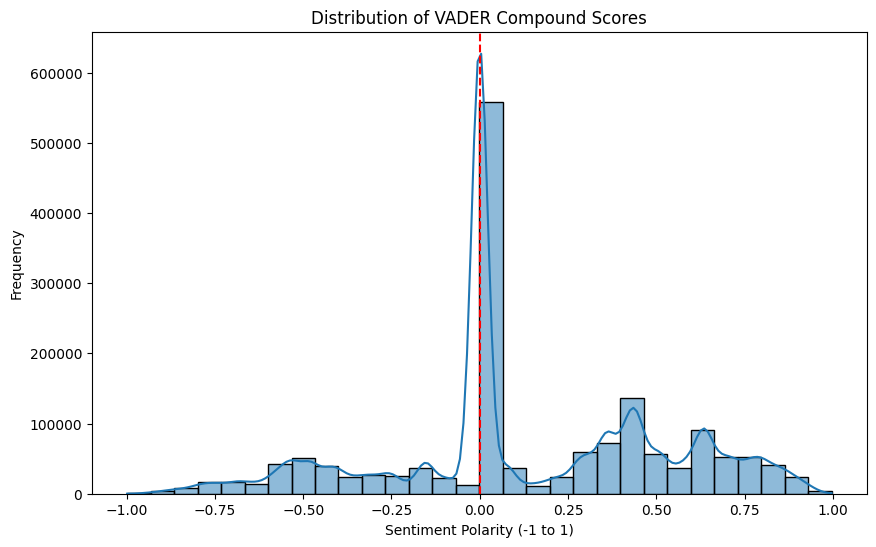

In [52]:
plt.figure(figsize=(10, 6))
sns.histplot(vader_df['compound'], bins=30, kde=True)
plt.title('Distribution of VADER Compound Scores')
plt.xlabel('Sentiment Polarity (-1 to 1)')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')  # Neutral line
plt.show()

In [74]:
from wordcloud import WordCloud

def generate_wordcloud(texts, title):
    wordcloud = WordCloud(width=800, height=400,
                        background_color='white',max_words=500,margin=1).generate(' '.join(texts))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis('off')
    plt.show()

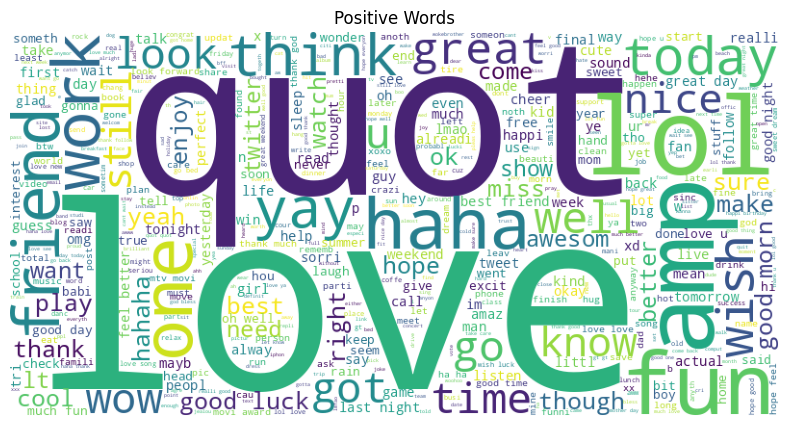

In [72]:
# Positive texts
generate_wordcloud(vader_df[vader_df['compound'] > 0.5]["cleaned_text"], 'Positive Words')

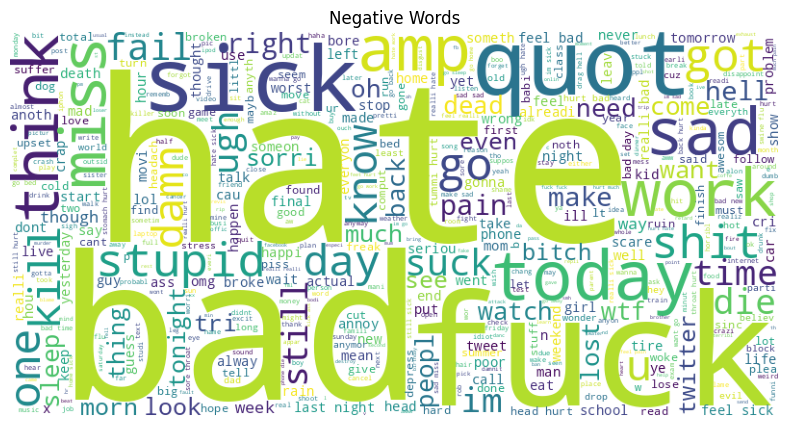

In [73]:
# Negative texts
generate_wordcloud(vader_df[vader_df['compound'] < -0.5]["cleaned_text"], 'Negative Words')

<h5>Bag-of-Words + Logistic Regression</h5>
<p>A supervised machine learning using:
<ul>
<li>Bag-of-Words (BoW) for feature extraction</li>
<li>Logistic Regression for classification</li>
<ul></p>



In [83]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [85]:
X=vader_df["cleaned_text"].values
y=vader_df["target"].values

In [91]:
vectorize=CountVectorizer()
X=vectorize.fit_transform(X)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [93]:
lr=LogisticRegression(max_iter=1000)
lr.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [95]:
x_train_pred=lr.predict(X_train)

In [94]:
x_test_pred=lr.predict(X_test)

In [96]:
print("Accuracy Score for Training Data = ",accuracy_score(x_train_pred,y_train))
print("Accuracy Score for Testing Data = ",accuracy_score(x_test_pred,y_test))

Accuracy Score for Training Data =  0.7969342163548565
Accuracy Score for Testing Data =  0.772853125


<h5>Saving Model</h5>

In [98]:
import pickle
file="BoW-logreg-model.pkl"
pickle.dump(lr,open(file,'wb'))